# Phishing email detection system

<hr>

<hr>

<hr>

<hr>

## Loading the dataset

In [20]:
import pandas as pd

In [21]:
dataframe = pd.read_csv("Phishing_Email.csv")

In [4]:
dataframe.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [5]:
dataframe['Email Type'].value_counts()

Email Type
Safe Email        11322
Phishing Email     7328
Name: count, dtype: int64

<hr>

<hr>

<hr>

<hr>

<hr>

## Preprocessing 

- We need to preprocess the dataset, in order to remove any numbers or special characters from the dataset.
- We also need to apply  <strong>SMOTE</strong> to handle the imbalance in the numbers of different type of emails.

In [22]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer


stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


# Define the preprocessing function
def preprocess_text(text):
    # Ensure the text is treated as a string
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove special characters except for common ones like @ and . in email addresses
    text = re.sub(r'[^a-zA-Z0-9@.\s]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text).strip()





    words = word_tokenize(text)

    filtered_sentence = [stemmer.stem(word) for word in words if word not in stop_words]


    return ' '.join(filtered_sentence)

<hr>

In [23]:

# Apply the preprocessing function to the email text
dataframe['Email Text'] = dataframe['Email Text'].apply(preprocess_text)


In [24]:
# Display the first few rows to ensure the preprocessing is done correctly
dataframe.head()

,Unnamed: 0,Email Text,Email Type
0,0,6 . 1100 disc uniformitarian 1086 sex lang dic...,Safe Email
1,1,side galicismo galicismo spanish term name imp...,Safe Email
2,2,equistar deal ticket still avail assist robert...,Safe Email
3,3,hello hot lil horni toy . one dream open mind ...,Phishing Email
4,4,softwar incred low price 86 lower . draperi se...,Phishing Email


<hr>

<hr>

## Feature extraction using TF-IDF vectorizer

- We now convert the text into numerical vectors, using the TF-IDF vectorizer.

- The TF-IDF vectorizer stands for: <strong>Term Frequency - Inverse Document Frequency vectorizer.</strong>

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Transform the email text into TF-IDF features
X = vectorizer.fit_transform(dataframe['Email Text']).toarray()

# Target variable
y = dataframe['Email Type']

In [26]:
X.shape

(18650, 5000)

### Saving the TFIDF vectorizer for later use

In [27]:
import pickle

In [28]:
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

print("Vectorizer saved successfully!")

Vectorizer saved successfully!


<hr>

<hr>

## Applying SMOTE

- Applying SMOTE to handle uneven quantity of the classes of the dataset

- SMOTE is <strong>Synthetic Minority Over-sampling Technique</strong>, used to resample data and create synthetic samples of phishing emails.

In [29]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the feature matrix and target variable
# 
# res stands for resampled.
X_res, y_res = smote.fit_resample(X, y)

# Display the new distribution of the target variable
pd.Series(y_res).value_counts()


Email Type
Safe Email        11322
Phishing Email    11322
Name: count, dtype: int64

<hr>

<hr>

<hr>

<hr>

## Splitting into Train and Test datasets

In [30]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)


<hr>

<hr>

<hr>

## Fitting data into various Machine Learning Models

- Now we need to fit these vectors into a machine learning model to be able to make predictions
- Various different  models that can be used are as follows:
  - Random forest
  - Decision Tree
  - Naive Bayes
  - Neural Networks

First I will create an evaluating function, to make measuring the accuracy easier

In [31]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



def evaluate_model(model, X_train, y_train, X_test, y_test):
    
    # Predict the labels for training and testing sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate accuracy for training and testing sets
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Print evaluation metrics
    print("Training Accuracy:", train_accuracy)
    print("Testing Accuracy:", test_accuracy)
    print("\nClassification Report for Training Set:\n", classification_report(y_train, y_train_pred))
    print("\nClassification Report for Testing Set:\n", classification_report(y_test, y_test_pred))
    
    # Visualize confusion matrix
    plot_confusion_matrix(y_train, y_train_pred, type(model).__name__)
    plot_confusion_matrix(y_test, y_test_pred, type(model).__name__)    




def plot_confusion_matrix(y_true, y_pred, model_name):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Safe Email', 'Phishing Email'], yticklabels=['Safe Email', 'Phishing Email'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()



### Decision Trees

In [15]:
from sklearn.tree import DecisionTreeClassifier

In [16]:

# Initialize the Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)


DecisionTreeClassifier(random_state=42)

Training Accuracy: 0.9911123378415677
Testing Accuracy: 0.9224994480017664

Classification Report for Training Set:
                 precision    recall  f1-score   support

Phishing Email       0.98      1.00      0.99      9007
    Safe Email       1.00      0.98      0.99      9108

      accuracy                           0.99     18115
     macro avg       0.99      0.99      0.99     18115
  weighted avg       0.99      0.99      0.99     18115


Classification Report for Testing Set:
                 precision    recall  f1-score   support

Phishing Email       0.91      0.94      0.93      2315
    Safe Email       0.93      0.90      0.92      2214

      accuracy                           0.92      4529
     macro avg       0.92      0.92      0.92      4529
  weighted avg       0.92      0.92      0.92      4529



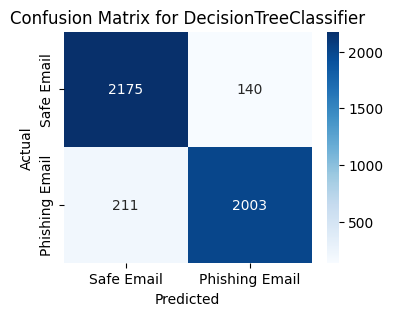

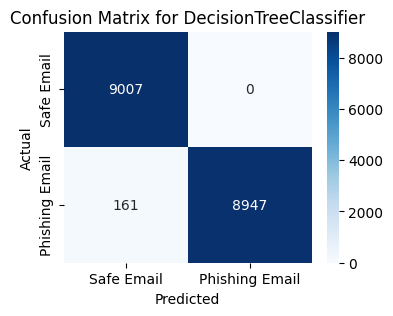

In [21]:
# Predict the labels for the test set
evaluate_model(dt_model, X_train, y_train, X_test, y_test)

<hr>

<hr>

### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Training Accuracy: 0.9911123378415677
Testing Accuracy: 0.9724000883197174

Classification Report for Training Set:
                 precision    recall  f1-score   support

Phishing Email       0.98      1.00      0.99      9007
    Safe Email       1.00      0.98      0.99      9108

      accuracy                           0.99     18115
     macro avg       0.99      0.99      0.99     18115
  weighted avg       0.99      0.99      0.99     18115


Classification Report for Testing Set:
                 precision    recall  f1-score   support

Phishing Email       0.96      0.99      0.97      2315
    Safe Email       0.99      0.96      0.97      2214

      accuracy                           0.97      4529
     macro avg       0.97      0.97      0.97      4529
  weighted avg       0.97      0.97      0.97      4529



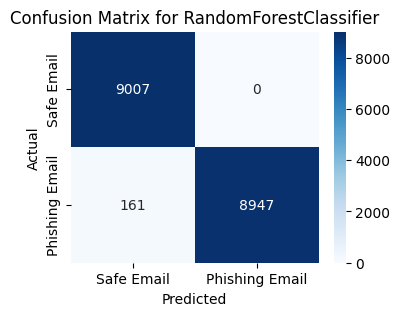

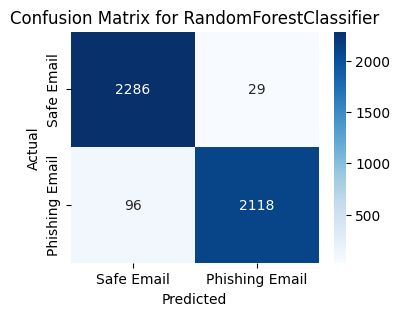

In [34]:
# Evaluate the Random Forest model
evaluate_model(rf_model, X_train, y_train, X_test, y_test)

<hr>

<hr>

### Support Vector Machine

In [20]:
# from sklearn.svm import SVC

In [21]:
# # Initialize the SVM Classifier
# svm_model = SVC(class_weight='balanced', random_state=42)

# # Train the model
# svm_model.fit(X_train, y_train)

In [22]:
# # Predict the labels for the test set
# evaluate_model(svm_model, X_test, y_test)

- Training a SVM model was taking too long
- Found out that the time complexity of training a Support Vector Machine is O(n^3) and the space complexity is O(n^2)
- Decided not to use this model

<hr>

<hr>

### Naive Bayes

In [26]:
from sklearn.naive_bayes import MultinomialNB

In [27]:
# Initialize the Naive Bayes Classifier
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train, y_train)

MultinomialNB()

Training Accuracy: 0.963621308308032
Testing Accuracy: 0.9571649370722014

Classification Report for Training Set:
                 precision    recall  f1-score   support

Phishing Email       0.96      0.97      0.96      9007
    Safe Email       0.97      0.96      0.96      9108

      accuracy                           0.96     18115
     macro avg       0.96      0.96      0.96     18115
  weighted avg       0.96      0.96      0.96     18115


Classification Report for Testing Set:
                 precision    recall  f1-score   support

Phishing Email       0.95      0.97      0.96      2315
    Safe Email       0.96      0.95      0.96      2214

      accuracy                           0.96      4529
     macro avg       0.96      0.96      0.96      4529
  weighted avg       0.96      0.96      0.96      4529



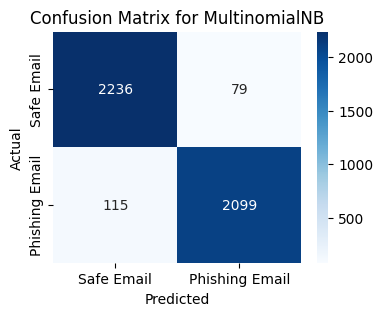

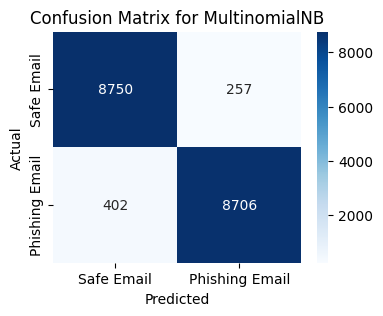

In [28]:
evaluate_model(nb_model, X_train, y_train, X_test, y_test)

<hr>

<hr>

## Saving the model for further use

After comparing the performance of each model, the Random Forest provides the best accuracy
So I will save the serialized model for further use in a webapp.

In [35]:
import pickle

In [36]:
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

print("Model saved successfully!")

Model saved successfully!


<hr>

<hr>

<hr>

<hr>

<hr>

<hr>

## Loading the model and trying to make predictions

After deciding which model to use, we want to use this model to make predictions

In [35]:
import pickle

In [40]:
# Load the model from the file
with open('random_forest_model.pkl', 'rb') as file:
    loaded_rf_model = pickle.load(file)

print("Model loaded successfully!")

Model loaded successfully!


In [41]:
# Load the model from the file
with open('tfidf_vectorizer.pkl', 'rb') as file:
    loaded_tfidf_vectorizer = pickle.load(file)

print("Model loaded successfully!")

Model loaded successfully!


<hr>

<hr>

In [38]:
safe_mail = '''	
Email Text
7	On Sun, Aug 11, 2002 at 11:17:47AM +0100, wintermute mentioned:
> > The impression I get from reading lkml the odd time is
> > that IDE has gone downhill since Andre Hedrick was 
> > effectively removed as maintainer. Martin Dalecki seems
> > to have been unable to further development without 
> > much breakage. 
> 
> Hmm... begs the question, why remove Handrick?
> If it ain't broke, don't fix it. See, the IDE subsystem is like the One Ring. It's kludginess, due to
having to support hundreds of dodgy chipsets & drives means that it is
inherintly evil. A few months of looking at the code can turn you sour.
Years of looking at it will turn you into an arsehole. They haven't found a hobbit that can code, so mortal humans have to
suffice. Kate
-- 
Irish Linux Users' Group: ilug@linux.ie
http://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.
List maintainer: listmaster@linux.ie
'''

phishing_mail = '''
	Email Text
224	the fastest way to get a loan we can help ! since 1965 redbrick lending has been here for you . 
with our recent reopening in addition to our launch of car financing and credit card services , we are now able to offer you a full range of services from credit cards to mortgages .
* credit cards secured or unsecured * business and personal large or small * debt consolidation good or bad credit * car financing * 1 st or 2 nd mortgage no application will be refused call today ( 866 ) 361 - 5036 or ( 866 ) 361 - 5038 or visit us online at www . redbricklending . biz proud member of the bbb red brick lending 14120 ballantyne corp .
place ste . # 200 charlotte , nc 28277 this e - mail message is an advertisement and / or solicitation .
'''

In [42]:


safe_mail = preprocess_text(safe_mail)
phishing_mail = preprocess_text(phishing_mail)

# print(safe_mail)
# print(phishing_mail)

safe_mail = loaded_tfidf_vectorizer.transform([safe_mail])
phishing_mail = loaded_tfidf_vectorizer.transform([phishing_mail])



prediction = loaded_rf_model.predict(safe_mail[0])
print(prediction[0])

prediction = loaded_rf_model.predict(phishing_mail[0])
print(prediction[0])

Safe Email
Phishing Email
